#### <font color='blue'> <h1 align="center"> Integrated Project : Data Mining Phase [Price Prediction Model] <br> 4GL_2022/2023 <br> <font color='red'></font> </h1> </font>

# Import libraries and data

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import r2_score

In [2]:
#Load dataset
data = pd.read_csv('./Train.csv')

# Data exploration
## Data dictionary:
### Our dataset has 2451 in function of 8 features which are:
    Product= Name of the product
    Product_Brand= Brand name
    Item_Category= Category of the product
    Subcategory_1= SubCategory of the product First Level
    Subcategory_2= SubCategory of the product Second Level
    Item_Rating= Rating of the product
    Date= Date of the transaction
    Selling_Price= Price of the product

>Note that the difference betwwen the item category and the two subcategories is only in terms of details. The subcategory 1 details more the item category and the 2nd level subcategory does the same with first level one.

In [3]:
#dataset size
data.shape

(2451, 8)

In [4]:
#Exploring non null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451 entries, 0 to 2450
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product        2451 non-null   object 
 1   Product_Brand  2451 non-null   object 
 2   Item_Category  2451 non-null   object 
 3   Subcategory_1  2451 non-null   object 
 4   Subcategory_2  2451 non-null   object 
 5   Item_Rating    2451 non-null   float64
 6   Date           2451 non-null   object 
 7   Selling_Price  2451 non-null   int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 153.3+ KB


> Our dataset doesn't contain NULL values

In [5]:
# Showing first five lines
data.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,02-03-17,291
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,07-01-15,897
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,01-12-19,792
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,12-12-14,837
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,12-12-13,470


In [6]:
# Eliminating Duplicates 
data=data.drop_duplicates()
data.shape

(2451, 8)

<AxesSubplot:>

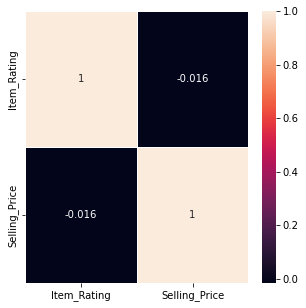

In [7]:
# Features correlation
fig, ax = plt.subplots(figsize=(5,5))  
sns.heatmap(data.corr(method="pearson"),annot=True,  linewidths=.5, ax=ax)

In [8]:
# Show data statistics
data.describe()

,Item_Rating,Selling_Price
count,2451.000000,2451.000000
mean,3.078335,2447.947776
std,1.187362,6734.982434
min,1.000000,33.000000
25%,2.000000,371.000000
50%,3.100000,596.000000
75%,4.100000,1194.500000
max,5.000000,70784.000000


Other features aren't considered in the visualizations and study because they are categorical features not numerical ones 

>=> Encoding will be necessary

In [9]:
# Different possible values for categories
print("Total distinct categories in", ":",len(data['Item_Category'].unique()))
print("Possible categories:\n",data['Item_Category'].value_counts())

Total distinct categories in : 75
Possible categories:
 clothing                                          717
jewellery                                         428
automotive                                        188
footwear                                          161
computers                                         104
                                                 ... 
shopoj white paper sky lantern 80 cm x 34 cm p      1
killys men s solid no show socks                    1
sj barstel 56m 1000m binoculars 30 mm black         1
prime printed 8 seater table cover multicolor       1
v g professional hd 37 hair dryer red               1
Name: Item_Category, Length: 75, dtype: int64


In [10]:
# Different possible values for Subcategories 1
print("Total distinct SubCategories 1 in", ":",len(data['Subcategory_1'].unique()))
print("Possible SubCategories1:\n",data['Subcategory_1'].value_counts())

Total distinct SubCategories 1 in : 130
Possible SubCategories1:
 women s clothing                 476
men s clothing                   174
accessories spare parts          173
necklaces chains                 160
rings                            139
                                ... 
bath and spa                       1
mp3 players ipods accessories      1
mangalsutras tanmaniyas            1
flowers plants vases               1
redex cat eye sunglasses           1
Name: Subcategory_1, Length: 130, dtype: int64


In [11]:
# Different possible values for Subcategories 2
print("Total distinct SubCategories 2 in", ":",len(data['Subcategory_2'].unique()))
print("Possible SubCategories2:\n",data['Subcategory_2'].value_counts())

Total distinct SubCategories 2 in : 336
Possible SubCategories2:
 western wear                           267
unknown                                228
necklaces                              158
car interior exterior                  126
lingerie sleep swimwear                108
                                      ... 
home audio                               1
brass gift center religion devotion      1
pens notebooks                           1
posters                                  1
fengshui                                 1
Name: Subcategory_2, Length: 336, dtype: int64


In [12]:
# Lines with the "unknown" value 
data.loc[data["Item_Category"]=="unknown"].shape

(0, 8)

In [13]:
# Lines with the "unknown" value 
data.loc[data["Subcategory_1"]=="unknown"].shape

(46, 8)

In [14]:
# Lines with the "unknown" value 
data.loc[data["Subcategory_2"]=="unknown"].shape

(228, 8)

## General observations:
-The features 'Product' and 'Product_Brand' though object type , can easily be converted into numeric by removing the char and separator to avoid encoding the data

-Item Category and Sucategory 1 & 2 features seem to have a lot of unique categorical values.

-Many unique values in Categories and both SubCategories
> Can't apply OneHotEncoder => Frequency Encoding is the solution

-Many 'Unkown' values in Categories and both SubCategories: No hierarchial relationship bw Item_Category-Subcategory1-Subcategory2 which affects the selling price.
>  Simply replace unkown by the category one level above

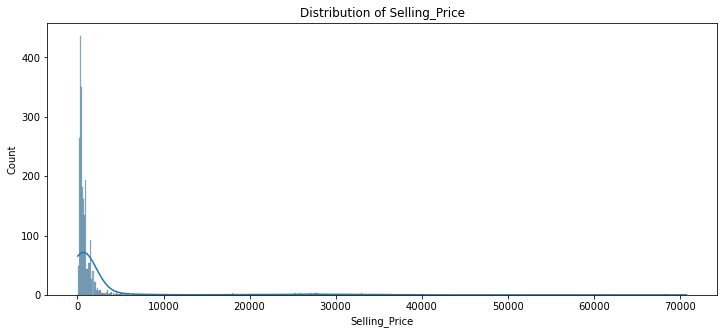

In [15]:
# Study of the distribution of selling_price values
plt.figure(figsize=(12,5))
plt.title("Distribution of Selling_Price")
ax = sns.histplot(data["Selling_Price"],kde=True)

> The Distribution of our target variable is highly left skewed => Transformation needed

# Data Preparation

In [16]:
# Log Transformation
data['Selling_Price'] = np.log(data['Selling_Price'])

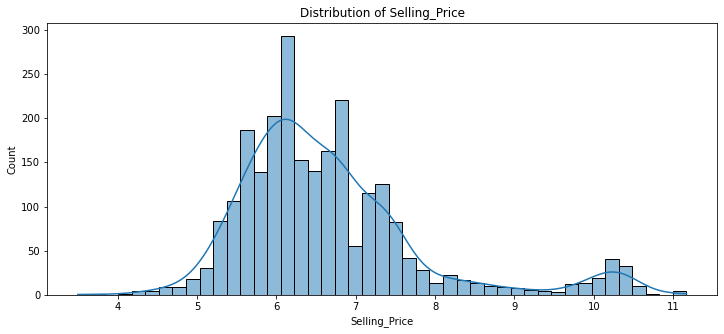

In [17]:
plt.figure(figsize=(12,5))
plt.title("Distribution of Selling_Price")
ax = sns.histplot(data["Selling_Price"],kde=True)

> Better distributed values

In [18]:
# Extracting numerical value from Product column
data['Product']=data['Product'].str.split('-', n=1, expand=True)[1]
data['Product'] = data['Product'].astype(int)

In [19]:
# Extracting numerical value from Product_Brand column
data['Product_Brand']=data['Product_Brand'].str.split('-', n=1, expand=True)[1]
data['Product_Brand'] = data['Product_Brand'].astype(int)

In [20]:
# Substuting unknown with values from higher level
data['Subcategory_1'] = np.where((data['Subcategory_1']=='unknown'),data['Item_Category'],data['Subcategory_1'])
data['Subcategory_2'] = np.where((data['Subcategory_2']=='unknown'),data['Subcategory_1'],data['Subcategory_2'])

In [21]:
# Frequency Encoding Categories
enc_nom = (data.groupby('Item_Category').size()) / len(data)
enc_nom
data['Item_Category_encode'] = data['Item_Category'].apply(lambda x : enc_nom[x])

In [22]:
# Frequencey encoding Subcategories 1
enc_nom = (data.groupby('Subcategory_1').size()) / len(data)
enc_nom
data['Subcategory_1_encode'] = data['Subcategory_1'].apply(lambda x : enc_nom[x])

In [23]:
# Frequencey encoding Subcategories 2
enc_nom = (data.groupby('Subcategory_2').size()) / len(data)
enc_nom
data['Subcategory_2_encode'] = data['Subcategory_2'].apply(lambda x : enc_nom[x])

In [24]:
# Results visualization
data

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price,Item_Category_encode,Subcategory_1_encode,Subcategory_2_encode
0,2610,659,bags wallets belts,bags,hand bags,4.3,02-03-17,5.673323,0.015504,0.011016,0.005304
1,2453,3078,clothing,women s clothing,western wear,3.1,07-01-15,6.799056,0.292534,0.194206,0.108935
2,6802,1810,home decor festive needs,showpieces,ethnic,3.5,01-12-19,6.674561,0.039984,0.014280,0.005712
3,4452,3078,beauty and personal care,eye care,h2o plus eye care,4.0,12-12-14,6.729824,0.036720,0.000816,0.000408
4,8454,3078,clothing,men s clothing,t shirts,4.3,12-12-13,6.152733,0.292534,0.070991,0.024888
...,...,...,...,...,...,...,...,...,...,...,...
2446,8870,2292,clothing,kids clothing,girls wear,2.3,11-03-17,6.608001,0.292534,0.027336,0.016320
2447,10672,3078,footwear,women s footwear,casual shoes,1.9,04-12-16,7.371489,0.065687,0.041208,0.028560
2448,2134,479,clothing,men s clothing,t shirts,1.9,19-04-19,6.902743,0.292534,0.070991,0.024888
2449,724,133,automotive,accessories spare parts,car interior exterior,2.7,01-12-14,7.376508,0.076703,0.070583,0.051408


## Feature Engineering

In [25]:
# Extracting Month and Year from Date
data['Date'] = pd.to_datetime(data['Date'])
data['Month'] = [date.month for date in data.Date]
data['Year'] = [date.year for date in data.Date]

## Data Scaling

In [26]:
# Scaling Data using MinMax strategy
data['Year'] = (data['Year'] - data['Year'].min()) / (data['Year'].max() - data['Year'].min())
data['Product'] = (data['Product'] - data['Product'].min()) / (data['Product'].max() - data['Product'].min())
data['Product_Brand'] = (data['Product_Brand'] - data['Product_Brand'].min()) / (data['Product_Brand'].max() - data['Product_Brand'].min())

## Finalizing the dataset

In [27]:
# Dropping old Columns
data.drop(['Item_Category','Subcategory_1','Subcategory_2','Date','Item_Rating'],axis=1,inplace = True)

In [28]:
# Prepared dataset
data

,Product,Product_Brand,Selling_Price,Item_Category_encode,Subcategory_1_encode,Subcategory_2_encode,Month,Year
0,0.207404,0.196359,5.673323,0.015504,0.011016,0.005304,2,0.625
1,0.194904,0.918233,6.799056,0.292534,0.194206,0.108935,7,0.375
2,0.541162,0.539839,6.674561,0.039984,0.014280,0.005712,1,0.875
3,0.354061,0.918233,6.729824,0.036720,0.000816,0.000408,12,0.250
4,0.672691,0.918233,6.152733,0.292534,0.070991,0.024888,12,0.125
...,...,...,...,...,...,...,...,...
2446,0.705812,0.683677,6.608001,0.292534,0.027336,0.016320,11,0.625
2447,0.849283,0.918233,7.371489,0.065687,0.041208,0.028560,4,0.500
2448,0.169506,0.142644,6.902743,0.292534,0.070991,0.024888,4,0.875
2449,0.057245,0.039391,7.376508,0.076703,0.070583,0.051408,1,0.250


In [29]:
# Data Statistics
data.describe()

,Product,Product_Brand,Selling_Price,Item_Category_encode,Subcategory_1_encode,Subcategory_2_encode,Month,Year
count,2451.000000,2451.000000,2451.000000,2451.000000,2451.000000,2451.000000,2451.000000,2451.000000
mean,0.496940,0.612154,6.648503,0.136984,0.063609,0.029703,5.698490,0.507650
std,0.283303,0.318440,1.174317,0.112677,0.068241,0.034185,4.361342,0.293236
min,0.000000,0.000000,3.496508,0.000408,0.000408,0.000408,1.000000,0.000000
25%,0.259992,0.332587,5.916202,0.036720,0.013872,0.003672,1.000000,0.250000
50%,0.489092,0.706953,6.390241,0.076703,0.031416,0.015504,5.000000,0.500000
75%,0.736027,0.918233,7.085483,0.292534,0.070991,0.051408,11.000000,0.750000
max,1.000000,1.000000,11.167388,0.292534,0.194206,0.108935,12.000000,1.000000


<AxesSubplot:>

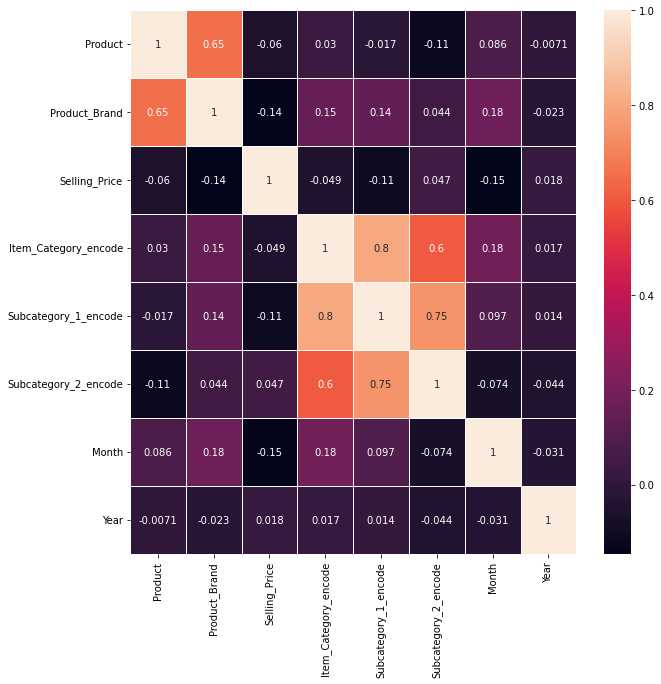

In [30]:
# Features Colleration
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(data.corr(method="pearson"),annot=True,  linewidths=.5, ax=ax)

# Modeling

In [31]:
# Split data into train and test
Y = data['Selling_Price']
X = data.drop('Selling_Price',axis=1)

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.1,random_state=0)

In [32]:
print(X_train.shape,Y_train.shape)

(2205, 7) (2205,)


In [33]:
# Tune best parameters for our model with gridsearch
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 500, num = 10)]
max_features = ['auto','sqrt']
min_samples_split = [4,5,6,7]
min_samples_leaf = [1]
bootstrap = [True]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [300, 322, 344, 366, 388, 411, 433, 455, 477, 500], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [4, 5, 6, 7], 'min_samples_leaf': [1], 'bootstrap': [True]}


In [34]:
# Find best parameters for RandomForestRegressor Model
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, Y_train)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 80 candidates, totalling 240 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1],
                                        'min_samples_split': [4, 5, 6, 7],
                                        'n_estimators': [300, 322, 344, 366,
                                                         388, 411, 433, 455,
                                                         477, 500]},
                   random_state=42, verbose=2)

In [35]:
# Get the best paramaters
rf_random.best_params_

{'n_estimators': 433,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'bootstrap': True}

In [36]:
# Run and fit the model
rf = RandomForestRegressor(n_estimators=366,
                           max_features='sqrt',
                           min_samples_leaf=1, 
                           min_samples_split = 4, 
                           random_state=100)
rf.fit(X_train,Y_train)

RandomForestRegressor(max_features='sqrt', min_samples_split=4,
                      n_estimators=366, random_state=100)

In [37]:
# Predict the values for the test split
y_pred = rf.predict(X_test)

In [38]:
# Assess the model using Root Mean Squared Error
mse = mean_squared_error(Y_test, y_pred)
rmse = math.sqrt(mse)
print(rmse)

0.707940055069729


In [39]:
# Assess the model using R-squared score
r2 = r2_score(Y_test, y_pred)
print(r2)

0.6600788584964092


In [40]:
# Run the model on the all the data
model=rf.fit(X,Y)

## Model Testing

In [41]:
# Importing test dataset (without the Price target)
test = pd.read_csv('./Test.csv')

### Test dataset Preparation

In [42]:
test['Product'] = test['Product'].str.split('-', n=1, expand=True)[1]
test['Product'] = test['Product'].astype(int)
test['Product_Brand'] = test['Product_Brand'].str.split('-', n=1, expand=True)[1]
test['Product_Brand'] = test['Product_Brand'].astype(int)

In [43]:
test['Subcategory_1'] = np.where((test['Subcategory_1']=='unknown'),test['Item_Category'],test['Subcategory_1'])
test['Subcategory_2'] = np.where((test['Subcategory_2']=='unknown'),test['Subcategory_1'],test['Subcategory_2'])

In [44]:
enc_nom = (test.groupby('Item_Category').size()) / len(test)
enc_nom
test['Item_Category_encode'] = test['Item_Category'].apply(lambda x : enc_nom[x])

In [45]:
enc_nom = (test.groupby('Subcategory_1').size()) / len(test)
enc_nom
test['Subcategory_1_encode'] = test['Subcategory_1'].apply(lambda x : enc_nom[x])

In [46]:
enc_nom = (test.groupby('Subcategory_2').size()) / len(test)
enc_nom
test['Subcategory_2_encode'] = test['Subcategory_2'].apply(lambda x : enc_nom[x])

In [47]:
test['Date'] = pd.to_datetime(test['Date'])
test['Month'] = [date.month for date in test.Date]
test['Year'] = [date.year for date in test.Date]

In [48]:
test.drop(['Item_Category','Subcategory_1','Subcategory_2','Date','Item_Rating'],axis=1,inplace = True)

## Running the model on the test dataset

In [49]:
pred = model.predict(test)
pred = np.abs(pred)
pred

array([7.61604477, 7.25041509, 6.71721044, ..., 6.99954398, 7.09586265,
       6.99954398])

## Example of execution data[0]

In [50]:
input_data=(0.207404,0.196359,0.015504,0.011016,0.005304,2,0.625)
input_data_as_numpy_array = np.asarray(input_data)
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)
prediction = model.predict(input_data_reshaped)
print(prediction)

[6.16537973]


> The model predicts 6.16 for the data[0] line while its real value is 5.67 which represnts a good prediction.